In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cvxpy as cp
import scipy
from sklearn.linear_model import LassoLars
from helper import *
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
m = 10
D = 1 * np.diag(1*np.random.rand(m)) # np.eye(m)
print(np.max(D)/np.min(np.diag(D)))
Dhalf = np.sqrt(D)
rank = 1
L = 1 * np.random.randn(m,rank)
X = scipy.linalg.sqrtm(D + L @ L.T)
y = 10*np.random.randn(m) - 3
p = X.T @ y

10.609218478767726


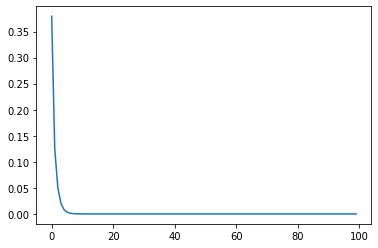

In [115]:
d, U, costs = factor_decomp(X.T @ X, rank = 3)
plt.figure()
plt.plot(costs)
plt.show()

In [116]:
## l0 brute force

if m <= 15:
    l0_costs, l0_supp = [], []
    M_list = []
    for k in range(1,m+1):
        supp, cost = l0_bruteforce(D + L @ L.T, p, k)
        l0_costs.append(cost)
        l0_supp.append(np.where(np.array(supp) == 1)[0])
        
        #solution
        idx = np.where(np.array(supp) == 1)[0]
        Xtilde = X[:, idx]
        sol = np.linalg.inv(Xtilde.T @ Xtilde) @ Xtilde.T @ y
        M_list.append(np.max(np.abs(sol)))

In [117]:
## dual solve

dual_costs, dual_supp = [], []
primal_feas_cost = []
for k in range(1,m+1):
    t, cost = cvx_dual(D, L, p, k)
    dual_idx = t.argsort()[-k:][::-1]
    dual_idx.sort()
    QQ = (D + L@ L.T)[dual_idx,:][:,dual_idx]
    pp = p[dual_idx]
    pf_cost = -1/2 * pp.T @ np.linalg.inv(QQ) @ pp
    dual_supp.append(dual_idx)
    dual_costs.append(-cost)
    primal_feas_cost.append(pf_cost)

In [118]:
## lasso solve
L1 = LassoLars(alpha=1e-3,fit_intercept=False, normalize=False)
L1.fit(X,y)
l1_supp, l1_sparsity = [], []
for c in L1.coef_path_.T:
    supp = np.where(c != 0)[0]
    l1_supp.append(supp)
    l1_sparsity.append(len(supp))
indexes = [l1_sparsity.index(x) for x in set(l1_sparsity)]
l1_sparsity = np.array(l1_sparsity)[np.array(indexes)[1:]]
l1_supp = [j for i, j in enumerate(l1_supp) if i in indexes][1:]
lasso_costs = []
for l1_idx in l1_supp:
    QQ = (D + L @ L.T)[l1_idx,:][:,l1_idx]
    pp = p[l1_idx]
    cost = -1/2 * pp.T @ np.linalg.inv(QQ) @ pp
    lasso_costs.append(cost)

In [119]:
l0_supp

[array([9]),
 array([8, 9]),
 array([0, 7, 9]),
 array([0, 7, 8, 9]),
 array([0, 1, 4, 7, 9]),
 array([0, 1, 4, 7, 8, 9]),
 array([0, 1, 4, 5, 7, 8, 9]),
 array([0, 1, 2, 4, 5, 7, 8, 9]),
 array([0, 1, 2, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

In [122]:
l0_costs

[-89.87177068701311,
 -101.76743792573474,
 -128.60593032039566,
 -144.04286127379893,
 -162.36254377676536,
 -176.80712468462042,
 -187.69564802900902,
 -188.72622242006517,
 -189.57327988858736,
 -190.0090501009967]

In [128]:
[b-a for a,b in zip(l0_costs,primal_feas_cost)]

[0.0, 7.720505162760716, 0.0, 4.692658091255879, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

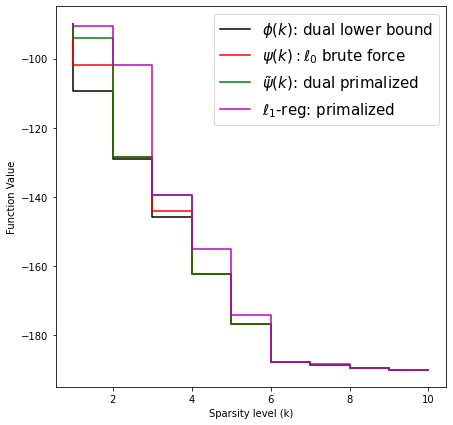

In [129]:
r = rank
plt.figure(figsize=(7,7))
plt.step(range(1,m+1), dual_costs, 'k-')
plt.step(range(1,m+1), l0_costs, 'r-')
plt.step(range(1,m+1), primal_feas_cost,'g-')
plt.step(l1_sparsity, lasso_costs,'m-')
#plt.step(range(r,m), dual_costs[:m-r], 'k--')
legend = [r'$\phi(k)$: dual lower bound',
          r'$\psi(k): \ell_0$ brute force',
          r'$\tilde{\psi}(k)$: dual primalized',
          r'$\ell_1$-reg: primalized',
          r'$\phi(k-\lfloor M(r+1) \rfloor)$']
plt.legend(legend, fontsize=15)
plt.ylabel('Function Value')
plt.xlabel('Sparsity level (k)')
plt.savefig(f'{m}_{rank}.pdf')

In [107]:
l1_sparsity

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [110]:
print([i for i in range(1,m+1)])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [1044]:
sdp_costs, sdp_supp = [], []
for k in range(1,m+1):
    x, c = cvx_sdp(D, L, p, k, verbose=False, solver=cp.SCS)
    sdp_costs.append(c)
    sdp_idx = x.argsort()[-k:][::-1]
    sdp_idx.sort()
    QQ = (D + L@ L.T)[sdp_idx,:][:,sdp_idx]
    pp = p[sdp_idx]
    sdp_cost = -1/2 * pp.T @ np.linalg.inv(QQ) @ pp
    print(sdp_cost)
    sdp_supp.append(sdp_idx)

-133.5517058565237
-331.10655756664096
-395.44380583957184
-439.3089467409672
-449.530878122849
-480.7391483006716
-497.64647182965166
-501.8709171915137
-505.3385249206445
-509.0601999589489


In [1045]:
sdp_costs

[-220.5556964622189,
 -338.83093765360564,
 -396.62721619706343,
 -439.3089910481523,
 -460.8097979881125,
 -480.985053450061,
 -497.64645721787025,
 -501.8709204137943,
 -505.46772669938116,
 -509.0602038090384]

In [1046]:
dual_costs

[-220.55560085074023,
 -338.83090002869096,
 -396.6272133704829,
 -439.30891479174625,
 -460.8097798033481,
 -480.9850181189658,
 -497.6464487659836,
 -501.8709052652373,
 -505.4680249315578,
 -509.06018503013263]

In [1047]:
l0_costs

[-133.5517058565237,
 -331.64735657508606,
 -395.44380583957184,
 -439.3089467409672,
 -453.93526688787097,
 -480.7391483006716,
 -497.64647182965166,
 -501.8709171915137,
 -505.3385249206445,
 -509.0601999589489]